In [1]:
# standard libraries
import pandas as pd
import numpy as np
import time
import re #regex

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data pre-processing
from sklearn.preprocessing import StandardScaler

# prediction models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics as mt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

### df_mat EDA

In [2]:
df_mat = pd.read_csv('unique_m.csv') 

In [3]:
df_mat.shape

(21263, 88)

In [4]:
df_mat.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [5]:
df_mat['critical_temp'].describe() 
# Heavily right-skewed response variable

count    21263.000000
mean        34.421219
std         34.254362
min          0.000210
25%          5.365000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

<AxesSubplot:xlabel='critical_temp', ylabel='Count'>

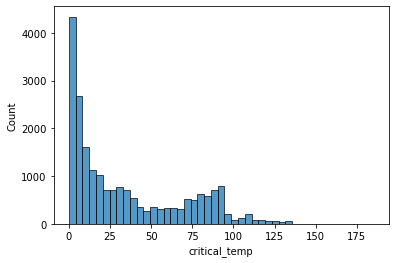

In [6]:
sns.histplot(df_mat['critical_temp'])
# Multi-modal as well with second peak at 75-90

<AxesSubplot:xlabel='critical_temp', ylabel='Count'>

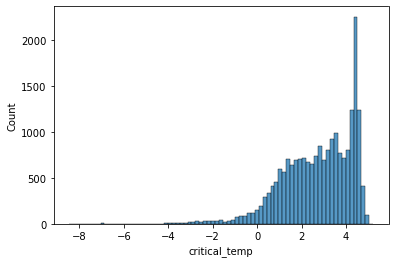

In [7]:
sns.histplot( np.log(df_mat['critical_temp']) )
# Not lognormal either...

In [8]:
mat_desc = df_mat.describe().T
mat_desc.tail()
# Some variables have all zeroes - no information (Po, At, Rn)

,count,mean,std,min,25%,50%,75%,max
Bi,21263.0,0.201009,0.655927,0.00000,0.000,0.0,0.0,14.0
Po,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
At,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
Rn,21263.0,0.000000,0.000000,0.00000,0.000,0.0,0.0,0.0
critical_temp,21263.0,34.421219,34.254362,0.00021,5.365,20.0,63.0,185.0


In [9]:
# Elements not present in any superconductors, all 0s
zero_elem = mat_desc.loc[mat_desc['mean']==0] 
zero_elem

,count,mean,std,min,25%,50%,75%,max
He,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ne,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ar,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kr,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xe,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pm,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Po,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
At,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rn,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Drop all elements that contain no information - will cause high VIF with modeling

drop_col = zero_elem.T.columns # Get the column names to drop
df_mat.drop(drop_col, axis=1, inplace=True)

In [11]:
df_mat.head() # Removed 9 elements

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp,material
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,Ba0.3La1.7Cu1O4


In [12]:
mat_desc[mat_desc['max'] > 99.99]

,count,mean,std,min,25%,50%,75%,max
B,21263.0,0.142594,1.044486,0.00000,0.000,0.0,0.0,105.000
C,21263.0,0.384968,4.408032,0.00000,0.000,0.0,0.0,120.000
Si,21263.0,0.189889,2.217277,0.00000,0.000,0.0,0.0,100.000
Mo,21263.0,0.146367,2.084302,0.00000,0.000,0.0,0.0,99.992
Cd,21263.0,0.009152,0.688729,0.00000,0.000,0.0,0.0,99.995
Pr,21263.0,0.041494,1.282059,0.00000,0.000,0.0,0.0,185.000
critical_temp,21263.0,34.421219,34.254362,0.00021,5.365,20.0,63.0,185.000


<AxesSubplot:xlabel='B'>

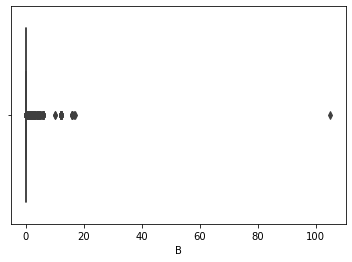

In [13]:
sns.boxplot(x = df_mat['B'])

# Outlier at B=105

<AxesSubplot:xlabel='C'>

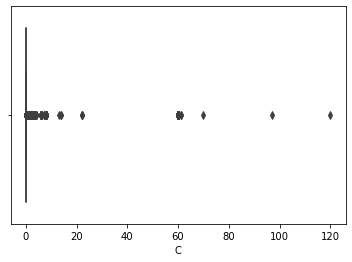

In [14]:
sns.boxplot(x = df_mat['C'])

# Skewed right, but no major outlier

<AxesSubplot:xlabel='Cd'>

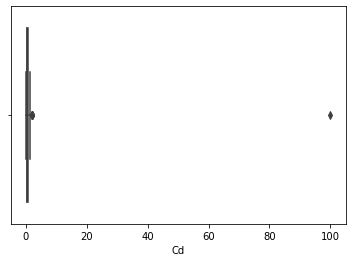

In [15]:
sns.boxplot(x = df_mat[df_mat['Cd']!=0]['Cd'])

# Outlier at Cd=99.995

<AxesSubplot:xlabel='Pr'>

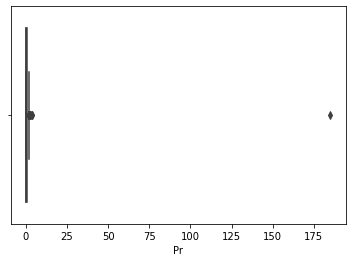

In [16]:
sns.boxplot(x = df_mat[df_mat['Pr']!=0]['Pr'])

# Outlier at Pr=185

<AxesSubplot:xlabel='Fe'>

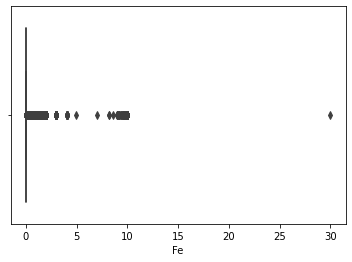

In [17]:
sns.boxplot(x = df_mat['Fe'])

# Outlier at Fe=30

<AxesSubplot:xlabel='Tc'>

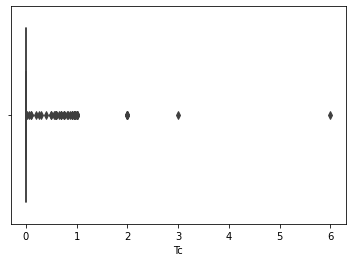

In [18]:
sns.boxplot(x = df_mat['Tc'])

### df_train EDA

In [19]:
df_train = pd.read_csv('train.csv') 

In [20]:
df_train.shape

(21263, 82)

In [21]:
df_train.head()
# Lots of redundant summary stats in this table

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [22]:
train_names = list(df_train.columns)

# regex to only keep wtd_mean... as summary stats from df_train
m = re.compile('wtd_mean|crit')
col_match = [m.match(i) for i in train_names]
col_names = [x for i,x in zip(col_match, train_names) if i!=None]

In [23]:
df_train[col_names].head()

,wtd_mean_atomic_mass,wtd_mean_fie,wtd_mean_atomic_radius,wtd_mean_Density,wtd_mean_ElectronAffinity,wtd_mean_FusionHeat,wtd_mean_ThermalConductivity,wtd_mean_Valence,critical_temp
0,57.862692,1010.268571,105.514286,2961.502286,111.727143,3.846857,61.015189,2.257143,29.0
1,58.518416,1010.612857,104.971429,3021.016571,112.316429,3.796857,61.372331,2.257143,26.0
2,57.885242,1010.820000,104.685714,2999.159429,112.213571,3.822571,60.943760,2.271429,19.0
3,57.873967,1010.544286,105.100000,2980.330857,111.970357,3.834714,60.979474,2.264286,22.0
4,57.840143,1009.717143,106.342857,2923.845143,111.240714,3.871143,61.086617,2.242857,23.0


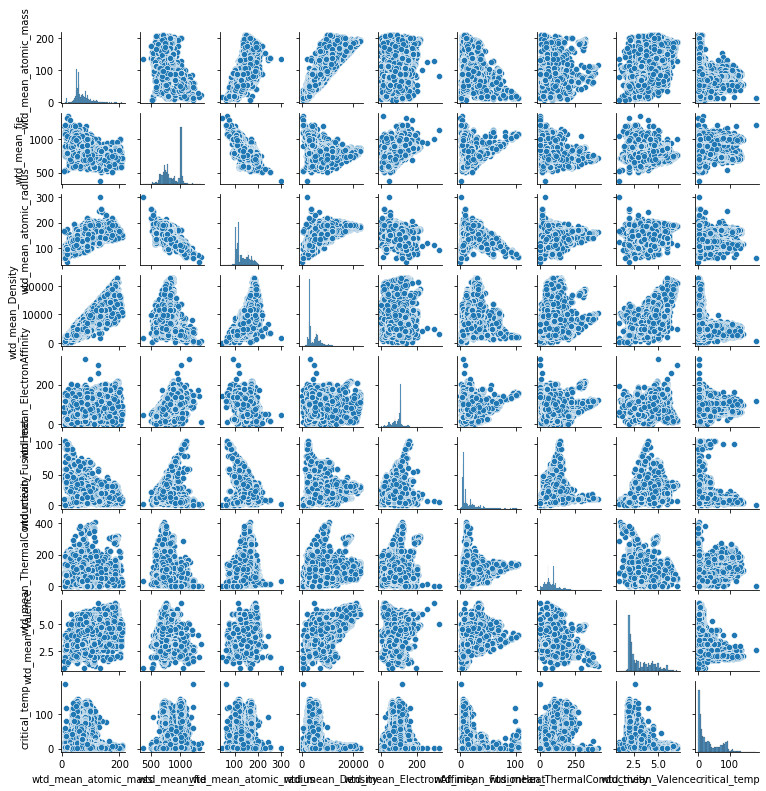

In [24]:
sns.pairplot(df_train[col_names], height=1.2)

## Visual correlation between wtd_mean_atomic_fie & wtd_mean_atomic_radius
## There appears to be a general lack of correlation between the explanatory variables and the response (bottom row)

In [25]:
temp_match = df_mat['critical_temp'] == df_train['critical_temp']
temp_match.describe()
# The 2 dataframes match for critical temp values for all rows and can likely be merged together

count     21263
unique        1
top        True
freq      21263
Name: critical_temp, dtype: object

In [26]:
col_names.pop()

'critical_temp'

In [29]:
# Define X

df_mat.drop(['critical_temp', 'material'], axis=1, inplace=True)
X = pd.concat([df_mat, df_train], axis=1)

# Remove outliers
X = X[ X['B'] < X['B'].max() ]
X = X[ X['Pr'] < X['Pr'].max() ]
X = X[ X['Cd'] < X['Cd'].max() ]
X = X[ X['Fe'] < X['Fe'].max() ]
X = X[ X['Tc'] < X['Tc'].max() ]
X = X[ X.index != 5918] # outlier in log transform models
print(X.shape)

# Define y

y = np.array( X['critical_temp'] )
X.drop(['critical_temp'], axis=1, inplace=True)
print(y.shape)

(21257, 159)
(21257,)


In [31]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234) 

# Center and Scale X
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train) # apply to training
X_test_scaled = scl.transform(X_test) # apply to the test set (without snooping/leakage)

# Keep the column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns, index = X_test.index)

### Baseline Model - Linear Regression with all terms

In [48]:
LR = LinearRegression()

# Cross validation on training set

LR_CV = cross_validate(LR, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
LR_CV_RMSE = [round(-i,2) for i in LR_CV['test_neg_root_mean_squared_error']]
print( "LinReg CV 5 Folds RMSE =", LR_CV_RMSE )
print( "LinReg CV Avg. RMSE =", round(np.mean(LR_CV_RMSE),2) )
LR_CV_Rsq = [round(i,3) for i in LR_CV['test_r2']]
print( "\nLinReg CV 5 Folds R-sq =", LR_CV_Rsq )
print( "LinReg CV Avg. R-sq =", round(np.mean(LR_CV_Rsq),3) )

# Training & Test Set

LR.fit(X_train_scaled, y_train)
y_hat_train = LR.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test = LR.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )

LinReg CV 5 Folds RMSE = [16.75, 16.54, 16.65, 16.68, 16.44]
LinReg CV Avg. RMSE = 16.61

LinReg CV 5 Folds R-sq = [0.756, 0.758, 0.758, 0.777, 0.765]
LinReg CV Avg. R-sq = 0.763

LinReg Training RMSE = 16.34
LinReg Training R-Sq = 0.771

LinReg Test RMSE = 16.86
LinReg Test R-Sq = 0.762


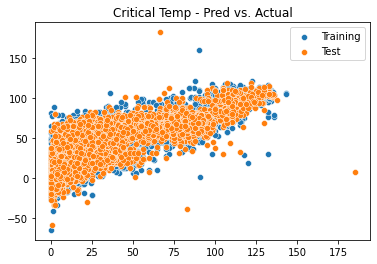

In [33]:
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()

# Model predicts negative critical_temp, need to transform so y is nonnegative

### Regression Model predicts negative critical_temp, transform so y is nonnegative
First, try just changing any negative predicted value to 0

In [49]:
y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )


LinReg Training RMSE = 16.09
LinReg Training R-Sq = 0.778

LinReg Test RMSE = 16.53
LinReg Test R-Sq = 0.771


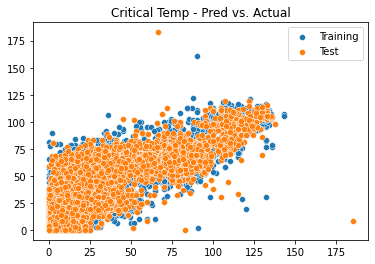

In [50]:
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()

### Log-Linear Model for Non-Zero Predictions

In [34]:
# Training & Test Set

LR.fit(X_train_scaled, np.log(y_train))
y_hat_train = LR.predict(X_train_scaled)
RMSE = round(mse(y_train, np.exp(y_hat_train), squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, np.exp(y_hat_train))
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test = LR.predict(X_test_scaled)
RMSE = round(mse(y_test, np.exp(y_hat_test), squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, np.exp(y_hat_test))
print( "LinReg Test R-Sq =", round(Rsq,3) )


LinReg Training RMSE = 17.03
LinReg Training R-Sq = 0.751

LinReg Test RMSE = 17.51
LinReg Test R-Sq = 0.743


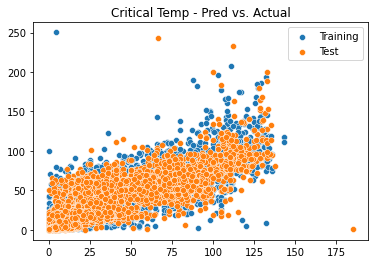

In [35]:
sns.scatterplot(x = y_train, y = np.exp(y_hat_train))
sns.scatterplot(x = y_test, y = np.exp(y_hat_test)).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()
# Training Outlier where y_hat=250
# Test Outlier where y=185

In [36]:
# Code to find visual outliers 
outlier_row = np.where(np.exp(y_hat_train) > 225)[0][0]
outlier_index = X_train_scaled.index[outlier_row]
outlier = X_train_scaled.loc[[outlier_index]]
outlierT = outlier.T
outlierT.columns = ['values > 3std']
outlierT.loc[outlierT['values > 3std']>3]

,values > 3std
V,17.864919
Fe,14.326030
Ga,23.287244


### Regularization with default alpha=1.0

In [37]:
L1 = Lasso(alpha = 1.0)

# Cross validation on training set
L1_CV = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
L1_CV_RMSE = [round(-i,2) for i in L1_CV['test_neg_root_mean_squared_error']]
print( "Lasso CV 5 Folds RMSE =", L1_CV_RMSE )
print( "Lasso CV Avg. RMSE =", np.mean(L1_CV_RMSE) )

L1_CV_Rsq = [round(i,3) for i in L1_CV['test_r2']]
print( "\nLasso CV 5 Folds R-Sq =", L1_CV_Rsq )
print( "Lasso CV Avg. R-Sq =", round(np.mean(L1_CV_Rsq),3) )

Lasso CV 5 Folds RMSE = [19.02, 18.88, 18.58, 19.31, 18.51]
Lasso CV Avg. RMSE = 18.86

Lasso CV 5 Folds R-Sq = [0.686, 0.685, 0.698, 0.701, 0.702]
Lasso CV Avg. R-Sq = 0.694


In [38]:
L2 = Ridge(alpha = 1.0)

# Cross validation on training set
L2_CV = cross_validate(L2, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
L2_CV_RMSE = [round(-i,2) for i in L2_CV['test_neg_root_mean_squared_error']]
print("Ridge CV 5 Folds RMSE =", L2_CV_RMSE)
print("Ridge CV Avg. RMSE =", round(np.mean(L2_CV_RMSE),2) )

L2_CV_Rsq = [round(i,3) for i in L2_CV['test_r2']]
print( "\nLasso CV 5 Folds R-Sq =", L2_CV_Rsq )
print( "Lasso CV Avg. R-Sq =", round(np.mean(L2_CV_Rsq),3) )

# Ridge gives better CV performance metrics with more terms in the model

Ridge CV 5 Folds RMSE = [16.77, 16.56, 16.66, 16.68, 16.43]
Ridge CV Avg. RMSE = 16.62

Lasso CV 5 Folds R-Sq = [0.756, 0.758, 0.757, 0.777, 0.765]
Lasso CV Avg. R-Sq = 0.763


### Tune alpha for LASSO
Decreasing alpha decreases the penalty and adds more model terms (higher variance, lower bias).

In [39]:
Lasso_df = []

for i in [0.06, 0.1, 0.5, 1]:
    L1.alpha = i
  
    # Cross validation on training set
    L1_CV = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
    L1_CV_RMSE = round(np.mean(-L1_CV['test_neg_root_mean_squared_error']), 3)
    L1_CV_Rsq = round(np.mean(L1_CV['test_r2']), 4)
    
    L1.fit(X_train_scaled, y_train)
    num_terms = len(L1.coef_[L1.coef_!=0])
    
    Lasso_df.append([ L1.alpha, num_terms, L1_CV_RMSE, L1_CV_Rsq ])
    
Lasso_df = pd.DataFrame(Lasso_df, columns = ['Lasso alpha', '# Terms', 'CV RMSE', 'CV R-squared'])
Lasso_df

# alpha = 0.06 is the best & lowest CV metrics without getting a convergence error
# However, increasing alpha=1.0 reduces the terms in the model which makes it easier to understand & interpret

,Lasso alpha,# Terms,CV RMSE,CV R-squared
0,0.06,113,17.115,0.7481
1,0.10,99,17.354,0.7411
2,0.50,46,18.220,0.7146
3,1.00,25,18.860,0.6943


### Select model terms with Lasso

In [40]:
L1 = Lasso(alpha = 1.0)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

model_coef = pd.DataFrame(zip(X.columns, L1.coef_), columns=['Factor','Coef'])
model_factors = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors.shape[0], "of", X.shape[1],"):")
model_coef[model_coef['Coef']!=0].sort_values(by='Coef')

Lasso Training RMSE = 18.75
Lasso Training R-Sq = 0.698

Lasso Test RMSE = 19.17
Lasso Test R-Sq = 0.692

Kept Factors( 25 of 158 ):


,Factor,Coef
121,wtd_gmean_ElectronAffinity,-3.205432
157,wtd_std_Valence,-3.119282
11,Si,-2.527797
110,gmean_Density,-1.709647
53,Pr,-1.502846
29,As,-0.733939
52,Ce,-0.552173
137,wtd_std_FusionHeat,-0.478352
54,Nd,-0.381264
141,wtd_gmean_ThermalConductivity,-0.098752


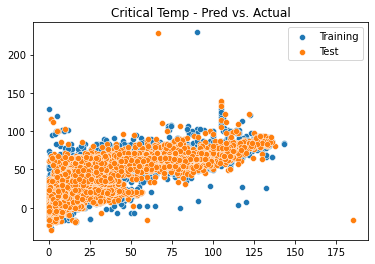

In [41]:
# Actual vs. Predicted - Lasso with alpha=1.0
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()

# 3 outliers with y > 175

### Final Ridge Model Built from Lasso Model Selection

In [42]:
L2 = Ridge(alpha = 1.0)
model_terms = list(model_factors['Factor'])
L2.fit(X_train_scaled[model_terms], y_train)

y_hat_train = L2.predict(X_train_scaled[model_terms])
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Ridge Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Ridge Training R-Sq =", round(Rsq,3) )

y_hat_test = L2.predict(X_test_scaled[model_terms])
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nRidge Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Ridge Test R-Sq =", round(Rsq,3) )

model_coef1 = pd.DataFrame(zip(X[model_terms].columns, L2.coef_), columns=['Factor','Coef'])
model_factors1 = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors1.shape[0], "of", X.shape[1],"):")
model_coef1[model_coef1['Coef']!=0].sort_values(by=['Coef'])

Ridge Training RMSE = 18.19
Ridge Training R-Sq = 0.716

Ridge Test RMSE = 18.54
Ridge Test R-Sq = 0.712

Kept Factors( 25 of 158 ):


,Factor,Coef
22,wtd_gmean_ThermalConductivity,-8.543023
24,wtd_std_Valence,-4.456707
0,Si,-3.535039
19,wtd_gmean_ElectronAffinity,-3.110701
18,gmean_Density,-2.764548
7,Pr,-2.249966
2,As,-1.234353
8,Nd,-1.225550
20,wtd_std_FusionHeat,-1.179501
4,Ag,-1.176605


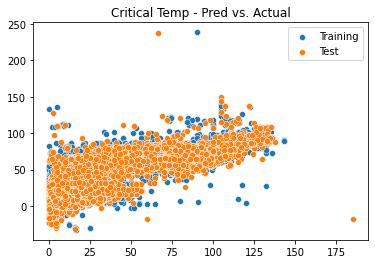

In [43]:
# Actual vs. Predicted - Ridge with alpha=1.0
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()

### Try adding 2-way interactions with kept model terms

In [44]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
intx = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_intx_train = pd.DataFrame( intx.fit_transform(X_train_scaled[model_terms]) )
X_intx_test = pd.DataFrame( intx.transform(X_test_scaled[model_terms]) )

Source for adding interactions: https://chrisalbon.com/code/machine_learning/linear_regression/adding_interaction_terms/#:~:text=%23%20Create%20interaction%20term%20%28not%20polynomial%20features%29%20interaction,Fit%20the%20linear%20regression%20model%20%3D%20regr.fit%28X_inter%2C%20y%29

In [45]:
X_intx_train.head()

,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,-0.084179,-0.2836,-0.142801,-0.438488,-0.046642,1.474281,-0.177415,-0.177618,-0.171759,-0.122329,...,-0.085866,0.183360,-0.304845,0.248869,-0.200214,0.332865,-0.271744,-0.710804,0.580285,-0.964752
1,-0.084179,-0.2836,-0.142801,-0.438488,-0.046642,-0.588210,-0.177415,-0.177618,-0.171759,-0.122329,...,-0.871425,-0.682673,-0.363319,2.560458,0.581806,0.309637,-2.182139,0.242569,-1.709485,-0.909787
2,-0.084179,-0.2836,-0.142801,-0.438488,-0.046642,-0.588210,-0.177415,-0.177618,-0.171759,-0.122329,...,-0.052743,0.083637,-0.127193,-0.047845,-0.369364,0.561718,0.211296,-0.890742,-0.335061,0.509551
3,-0.084179,-0.2836,-0.142801,-0.438488,-0.046642,0.443036,-0.177415,-0.177618,-0.171759,-0.122329,...,0.235907,0.291407,-0.231126,0.367563,0.356678,-0.282894,0.449891,-0.349449,0.555734,-0.440774
4,-0.084179,-0.2836,-0.142801,-0.438488,-0.046642,1.505218,-0.177415,-0.177618,-0.171759,-0.122329,...,-0.080689,0.188301,-0.305240,0.236748,-0.181492,0.294202,-0.228187,-0.686567,0.532510,-0.863207


In [46]:
L1 = Lasso(alpha = 1.5)
L1.fit(X_intx_train, y_train)

y_hat_train = L1.predict(X_intx_train)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_intx_test)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

print("\nAdded", len(L1.coef_[L1.coef_!=0]) - model_factors.shape[0], 
      "two-way interaction terms that improved the model prediction") 

Lasso Training RMSE = 17.36
Lasso Training R-Sq = 0.741

Lasso Test RMSE = 17.95
Lasso Test R-Sq = 0.73

Added 9 two-way interaction terms that improved the model prediction


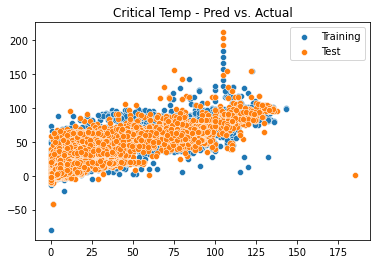

In [47]:
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.show()